In [1]:
pip install scikit-optimize

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.5 MB/s eta 0:00:00


In [2]:
# Imports necessários
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from skopt import BayesSearchCV

In [3]:
# Carregar o dataset de vinhos a partir da URL
url = "https://raw.githubusercontent.com/klaytoncastro/idp-machinelearning/main/decision-tree/winequality-merged.csv"
data = pd.read_csv(url)
data['color'] = data['color'].replace('red', 0)
data['color'] = data['color'].replace('white', 1)
data['worst'] = np.where(data['quality'] < 7, 1, 0)
data = data.drop(['quality'], axis=1)
data.head()

<ipython-input-3-631f6aa96ddf>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['color'] = data['color'].replace('white', 1)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color,worst
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,1,1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,1,1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,1,1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1,1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,1,1


In [4]:
# Dividir o dataset em treino e teste
X = data.drop('worst', axis=1)
y = data['worst']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Instanciar o modelo de Extra Trees
model = ExtraTreesClassifier(random_state=42)

# Random
param_random = {
    'n_estimators': [100, 200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

In [9]:
# Aplicando o RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_random,
                                   n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Treinando o modelo com Randomized Search
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
96 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
96 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/

RandomizedSearchCV(cv=3, estimator=ExtraTreesClassifier(random_state=42),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20, 30, 40],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 500, 1000]},
                   random_state=42, verbose=2)

In [10]:
best_params_random = random_search.best_params_
print("Melhores parâmetros (Random Search):", best_params_random)

Melhores parâmetros (Random Search): {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': None}


In [17]:
#grid
param_grid = {
    'n_estimators': [best_params_random['n_estimators']],
    'max_features': [best_params_random['max_features']],
    'max_depth': [best_params_random['max_depth']],
    'min_samples_split': [best_params_random['min_samples_split']],
    'min_samples_leaf': [best_params_random['min_samples_leaf']],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


GridSearchCV(cv=5, estimator=ExtraTreesClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False], 'max_depth': [None],
                         'max_features': ['log2'], 'min_samples_leaf': [1],
                         'min_samples_split': [2], 'n_estimators': [200]},
             verbose=1)

In [20]:
best_params_grid = grid_search.best_params_
print("Melhores parâmetros (Grid Search):", best_params_grid)

Melhores parâmetros (Grid Search): {'bootstrap': False, 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [29]:
param_bayes = {
    'n_estimators': [best_params_grid['n_estimators']],
    'max_features': [best_params_grid['max_features']],
    'max_depth': [best_params_grid['max_depth']],
    'min_samples_split': [best_params_grid['min_samples_split']],
    'min_samples_leaf': [best_params_grid['min_samples_leaf']],
}

# Aplicando a Otimização Bayesiana com BayesSearchCV
bayes_search = BayesSearchCV(estimator=model, search_spaces=param_bayes, n_iter=32, cv=3, verbose=2, random_state=42, n_jobs=-1)

# Treinando o modelo com a Otimização Bayesiana
bayes_search.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits
Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [None, 'log2', 1, 2, 200] before, using random point [None, 'log2', 1, 2, 200]
  warnings.warn(


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


BayesSearchCV(cv=3, estimator=ExtraTreesClassifier(random_state=42), n_iter=32,
              n_jobs=-1, random_state=42,
              search_spaces={'max_depth': [None], 'max_features': ['log2'],
                             'min_samples_leaf': [1], 'min_samples_split': [2],
                             'n_estimators': [200]},
              verbose=2)

In [23]:
best_params_bayes = bayes_search.best_params_
print("Melhores parâmetros (Bayes Search):", best_params_bayes)

Melhores parâmetros (Bayes Search): OrderedDict([('max_depth', None), ('max_features', 'log2'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 200)])


In [24]:
y_pred_bayes = bayes_search.predict(X_test)
print("\nAcurácia (Bayes Search):", bayes_search.score(X_test, y_test))


Acurácia (Bayes Search): 0.8892307692307693


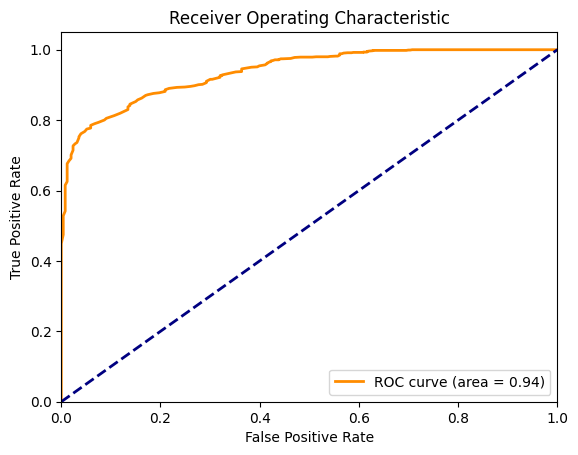

In [25]:
y_probs = bayes_search.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plotar a curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [27]:
"""
Calculando e exibindo a matriz de confusão. A orientação padrão é a seguinte:
[0,0]: Verdadeiros Negativos (VN) - Previsões corretamente identificadas como negativas.
[0,1]: Falsos Positivos (FP) - Previsões incorretamente identificadas como positivas.
[1,0]: Falsos Negativos (FN) - Previsões incorretamente identificadas como negativas.
[1,1]: Verdadeiros Positivos (VP) - Previsões corretamente identificadas como positivas.
"""

conf_matrix = confusion_matrix(y_test, y_pred_bayes)
print("Matriz de Confusão:")
print(conf_matrix)

Matriz de Confusão:
[[ 131  122]
 [  22 1025]]


In [28]:
# Relatório de classificação e matriz de confusão
print("\nRelatório de Classificação (Bayes Search):")
print(classification_report(y_test, y_pred_bayes, zero_division=0))


Relatório de Classificação (Bayes Search):
              precision    recall  f1-score   support

           0       0.86      0.52      0.65       253
           1       0.89      0.98      0.93      1047

    accuracy                           0.89      1300
   macro avg       0.87      0.75      0.79      1300
weighted avg       0.89      0.89      0.88      1300

